# 51421326_Riska Septyani_4IA20_Kelas E

# Deteksi Hate Speech dan Offensive Language di Twitter

-----------------------------------------------------------

Tugas ini merupakan tugas akhir pada kelas LSP Data Science di Universitas Gunadarma.

In [28]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [29]:
import re
import nltk
from nltk.util import pr
stemmer = nltk.SnowballStemmer('english')
from nltk.corpus import stopwords
import string
stopword = set(stopwords.words('english'))

# DATA UNDERSTANDING

In [30]:
df = pd.read_csv('train.csv')

In [31]:
print(df.head())


   count  hate_speech_count  offensive_language_count  neither_count  class  \
0      3                  0                         0              3      2   
1      3                  0                         3              0      1   
2      3                  0                         3              0      1   
3      3                  0                         2              1      1   
4      6                  0                         6              0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


In [32]:
print(df.tail())

       count  hate_speech_count  offensive_language_count  neither_count  \
24778      3                  0                         2              1   
24779      3                  0                         1              2   
24780      3                  0                         3              0   
24781      6                  0                         6              0   
24782      3                  0                         0              3   

       class                                              tweet  
24778      1  you's a muthaf***in lie &#8220;@LifeAsKing: @2...  
24779      2  you've gone and broke the wrong heart baby, an...  
24780      1  young buck wanna eat!!.. dat nigguh like I ain...  
24781      1              youu got wild bitches tellin you lies  
24782      2  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...  


In [33]:
df.shape

(24783, 6)

In [34]:
print("Jumlah Baris : ", df.shape[0])
print("Jumlah Kolom : ", df.shape[1])

Jumlah Baris :  24783
Jumlah Kolom :  6


In [35]:
df.describe(include='all')

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783
unique,NaN,NaN,NaN,NaN,NaN,24783
top,NaN,NaN,NaN,NaN,NaN,!!! RT @mayasolovely: As a woman you shouldn't...
freq,NaN,NaN,NaN,NaN,NaN,1
mean,3.243473,0.280515,2.413711,0.549247,1.110277,NaN
std,0.883060,0.631851,1.399459,1.113299,0.462089,NaN
min,3.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,3.000000,0.000000,2.000000,0.000000,1.000000,NaN
50%,3.000000,0.000000,3.000000,0.000000,1.000000,NaN
75%,3.000000,0.000000,3.000000,0.000000,1.000000,NaN


# DATA PREPARATION

In [36]:
df.isna().sum()

count                       0
hate_speech_count           0
offensive_language_count    0
neither_count               0
class                       0
tweet                       0
dtype: int64

Tidak ada kolom yang memiliki nilai data yang kosong, maka tidak perlu dilakukannya imputasi.

In [37]:
# Melakukan Mapping
df['labels'] = df['class'].map({0:'Hate Speech Detected',
                                1:'Offensive language detected',
                                })
print(df.head())

   count  hate_speech_count  offensive_language_count  neither_count  class  \
0      3                  0                         0              3      2   
1      3                  0                         3              0      1   
2      3                  0                         3              0      1   
3      3                  0                         2              1      1   
4      6                  0                         6              0      1   

                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                        labels  
0                          NaN  
1  Offensive language detected  
2  Offensive language detected  
3  Offensive language detected  
4  Offensive language d

In [38]:
df = df[['tweet', 'labels']]
df.head()

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,NaN
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive language detected
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive language detected
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive language detected
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive language detected


#### Cleaning

In [39]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\. \S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = ' '.join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = ' '.join(text)
    return text

df['tweet'] = df['tweet'].apply(clean)
print(df.head())

                                               tweet  \
0   rt mayasolov woman shouldnt complain clean ho...   
1   rt  boy dat coldtyga dwn bad cuffin dat hoe  ...   
2   rt urkindofbrand dawg rt  ever fuck bitch sta...   
3             rt cganderson vivabas look like tranni   
4   rt shenikarobert shit hear might true might f...   

                        labels  
0                          NaN  
1  Offensive language detected  
2  Offensive language detected  
3  Offensive language detected  
4  Offensive language detected  


In [40]:
df = df.dropna(subset=['tweet', 'labels'])

#### Mengatasi Outlier

In [41]:
df['length'] = df['tweet'].apply(len)

print(df.head()) 
print("Kolom yang tersedia:", df.columns) 

max_length = 100

outliers = df[df['length'] > max_length]
if not outliers.empty:
    print("Deteksi Outlier:")
    print(outliers[['tweet', 'length']])
else:
    print("Tidak ada outlier yang terdeteksi.")

                                               tweet  \
1   rt  boy dat coldtyga dwn bad cuffin dat hoe  ...   
2   rt urkindofbrand dawg rt  ever fuck bitch sta...   
3             rt cganderson vivabas look like tranni   
4   rt shenikarobert shit hear might true might f...   
5  tmadisonx shit blow meclaim faith somebodi sti...   

                        labels  length  
1  Offensive language detected      51  
2  Offensive language detected      64  
3  Offensive language detected      39  
4  Offensive language detected      65  
5  Offensive language detected      58  
Kolom yang tersedia: Index(['tweet', 'labels', 'length'], dtype='object')
Deteksi Outlier:
                                                   tweet  length
131    girlthatsvont yall still go trick treat year n...     105
139    heartlessfuck glad im get outta atlanta noth b...     104
183    mannydiesel def cowboy lol rt artoffloyd terre...     106
253    thenewsat newsatquestionsyeah bitch yeah bitch...     101
3

In [42]:
# Menghapus outlier
df = df[df['length'] <= max_length]
print("Jumlah data setelah menghapus outlier:", df.shape[0])

Jumlah data setelah menghapus outlier: 20432


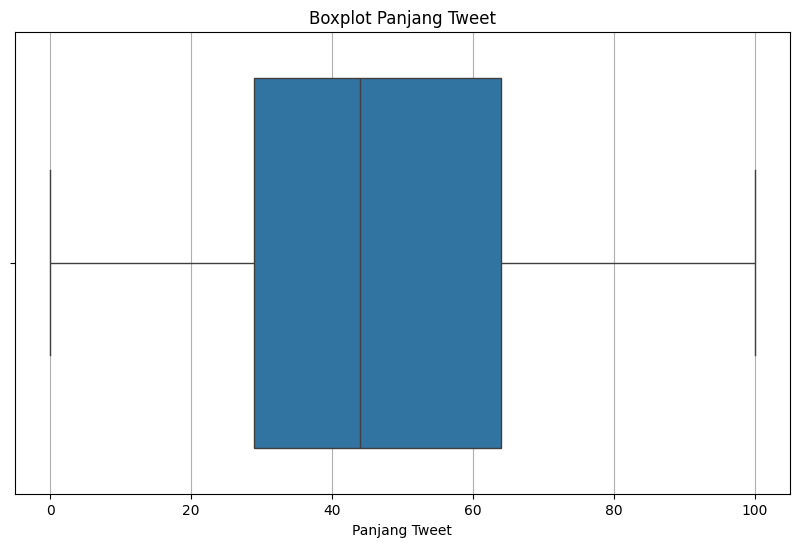

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

df['length'] = df['tweet'].apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(x='length', data=df)
plt.title('Boxplot Panjang Tweet')
plt.xlabel('Panjang Tweet')
plt.grid(axis='x')
plt.show()

# MODELLING

In [44]:
x = np.array(df["tweet"])
y = np.array(df["labels"])

# Melakukan Encoding
cv = CountVectorizer()
x = cv.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size= 0.3, random_state=42)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

# EVALUASI

In [45]:
# Setelah model dilatih
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Melakukan prediksi pada data pengujian
y_pred = clf.predict(X_test)

# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)

print(f"Akurasi model: {accuracy * 100:.2f}%")

Akurasi model: 91.92%


In [46]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 146  267]
 [ 228 5489]]


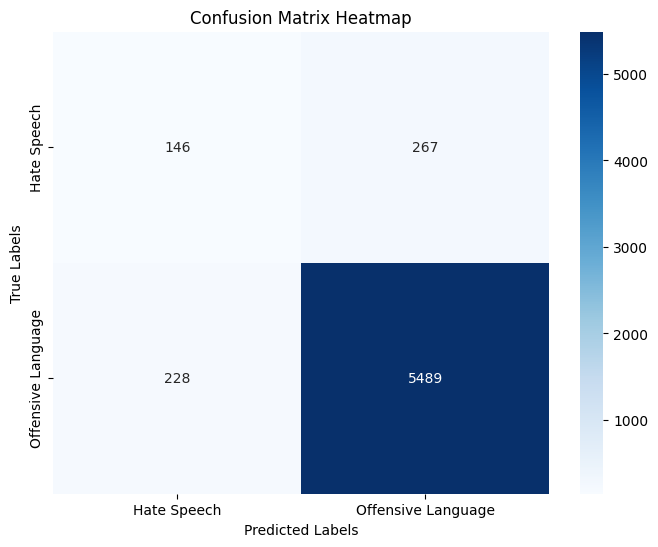

In [47]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive Language'], yticklabels=['Hate Speech', 'Offensive Language'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [48]:
report = classification_report(y_test, y_pred, target_names=['Hate Speech', 'Offensive Language'])
print("\nClassification Report:")
print(report)


Classification Report:
                    precision    recall  f1-score   support

       Hate Speech       0.39      0.35      0.37       413
Offensive Language       0.95      0.96      0.96      5717

          accuracy                           0.92      6130
         macro avg       0.67      0.66      0.66      6130
      weighted avg       0.92      0.92      0.92      6130



In [49]:
test_data = 'I will kill you!'
df = cv.transform([test_data]).toarray()
print(clf.predict(df))

['Hate Speech Detected']


In [50]:
test_data = 'you uggly!'
df = cv.transform([test_data]).toarray()
print(clf.predict(df))

['Offensive language detected']


In [51]:
import joblib

# Menyimpan model
joblib.dump(clf, 'model.pkl')

# Memuat model
loaded_model = joblib.load('model.pkl')